In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
import missingno as msno
import lightgbm as lgb
import optuna

# Suppress warnings
warnings.filterwarnings('ignore')

# Data preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Sampling and pipelines (from imbalanced-learn)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Model training
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import early_stopping, LGBMClassifier


# Model selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    KFold,
    learning_curve
)

# Model evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Statistical tools
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Exploratory Data Analysis
## Import Data

In [3]:
df = pd.read_csv('onlinefraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Inspect Basics

## Advanced Data Quality Assessment

- Prior to moving on with the analysis, we will be conducting a detailed quality assessment to make sure that the results are reliable and our models will perform at their best.

In [4]:
# Comprehensive Data Quality Assessment
def assess_data_quality(df):
    """
    Perform comprehensive data quality assessment
    """
    print("="*80)
    print("COMPREHENSIVE DATA QUALITY ASSESSMENT")
    print("="*80)

    # 1. Basic Dataset Information
    print(f"\nDataset Overview:")
    print(f"   • Shape: {df.shape}")
    print(f"   • Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   • Data Types: {df.dtypes.value_counts().to_dict()}")

    # 2. Missing Values Analysis
    print(f"\nMissing Values Analysis:")
    missing_stats = df.isnull().sum()
    missing_pct = (missing_stats / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_stats,
        'Missing_Percentage': missing_pct
    }).round(2)

    if missing_stats.sum() > 0:
        print("   Columns with missing values:")
        print(missing_summary[missing_summary['Missing_Count'] > 0].to_string())
    else:
        print("   No missing values found!")

    # 3. Duplicate Records Analysis
    print(f"\nDuplicate Analysis:")
    duplicates = df.duplicated().sum()
    print(f"   • Total duplicates: {duplicates} ({(duplicates/len(df)*100):.2f}%)")

    # 4. Categorical Data Analysis
    print(f"\nCategorical Features Analysis:")
    cat_columns = df.select_dtypes(include=['object']).columns
    for col in cat_columns:
        unique_vals = df[col].nunique()
        print(f"   • {col}: {unique_vals:,} unique values")
        if unique_vals <= 10:
            print(f"     Values: {df[col].unique().tolist()}")

    # 5. Numerical Data Analysis
    print(f"\n Numerical Features Analysis:")
    num_columns = df.select_dtypes(include=[np.number]).columns
    for col in num_columns:
        zeros = (df[col] == 0).sum()
        negatives = (df[col] < 0).sum()
        print(f"   • {col}: {zeros:,} zeros ({zeros/len(df)*100:.1f}%), {negatives:,} negatives")

    # 6. Target Variable Analysis
    if 'isFraud' in df.columns:
        print(f"\nTarget Variable Analysis (isFraud):")
        fraud_dist = df['isFraud'].value_counts()
        imbalance_ratio = fraud_dist[0] / fraud_dist[1] if len(fraud_dist) > 1 else "N/A"
        print(f"   • Class 0 (Non-Fraud): {fraud_dist[0]:,} ({fraud_dist[0]/len(df)*100:.2f}%)")
        print(f"   • Class 1 (Fraud): {fraud_dist[1]:,} ({fraud_dist[1]/len(df)*100:.2f}%)")
        print(f"   • Imbalance Ratio: {imbalance_ratio:.1f}:1")

    # 7. Data Consistency Checks
    print(f"\n🔧 Data Consistency Checks:")
    consistency_issues = []

    # Check if amounts are non-negative
    if 'amount' in df.columns:
        negative_amounts = (df['amount'] < 0).sum()
        if negative_amounts > 0:
            consistency_issues.append(f"Negative amounts: {negative_amounts}")

    # Check balance consistency (if new balance columns exist)
    if all(col in df.columns for col in ['oldbalanceOrg', 'newbalanceOrig', 'amount']):
        # This is a simplified check - in reality, balance changes are more complex
        expected_balance = df['oldbalanceOrg'] - df['amount']
        balance_inconsistencies = (df['newbalanceOrig'] != expected_balance).sum()
        print(f"   • Balance inconsistencies: {balance_inconsistencies:,} transactions")

    if consistency_issues:
        print("   Issues found:")
        for issue in consistency_issues:
            print(f"      - {issue}")
    else:
        print("   No major consistency issues found!")

    return missing_summary

# Run comprehensive data quality assessment
quality_report = assess_data_quality(df)

COMPREHENSIVE DATA QUALITY ASSESSMENT

Dataset Overview:
   • Shape: (6362620, 11)
   • Memory Usage: 1598.19 MB
   • Data Types: {dtype('float64'): 5, dtype('int64'): 3, dtype('O'): 3}

Missing Values Analysis:
   No missing values found!

Duplicate Analysis:
   • Total duplicates: 0 (0.00%)

Categorical Features Analysis:
   • type: 5 unique values
     Values: ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
   • nameOrig: 6,353,307 unique values
   • nameDest: 2,722,362 unique values

 Numerical Features Analysis:
   • step: 0 zeros (0.0%), 0 negatives
   • amount: 16 zeros (0.0%), 0 negatives
   • oldbalanceOrg: 2,102,449 zeros (33.0%), 0 negatives
   • newbalanceOrig: 3,609,566 zeros (56.7%), 0 negatives
   • oldbalanceDest: 2,704,388 zeros (42.5%), 0 negatives
   • newbalanceDest: 2,439,433 zeros (38.3%), 0 negatives
   • isFraud: 6,354,407 zeros (99.9%), 0 negatives
   • isFlaggedFraud: 6,362,604 zeros (100.0%), 0 negatives

Target Variable Analysis (isFraud):
   • Class

Column | Description
-------------------|------------------
`step` | represents a unit of time where 1 step equals 1 hour
`amount` | the amount of the transaction
`nameOrig` | customer starting the transaction
`oldbalanceOrg` | balance before the transaction
`newbalanceOrig` | balance after the transaction
`nameDest` | recipient of the transaction
`oldbalanceDest` | initial balance of recipient before the transaction
`newbalanceDest` | the new balance of recipient after the transaction
`isFraud` | fraud transaction



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Summary statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Data Visualization

### Correlation Between Numerical Columns

<Axes: >

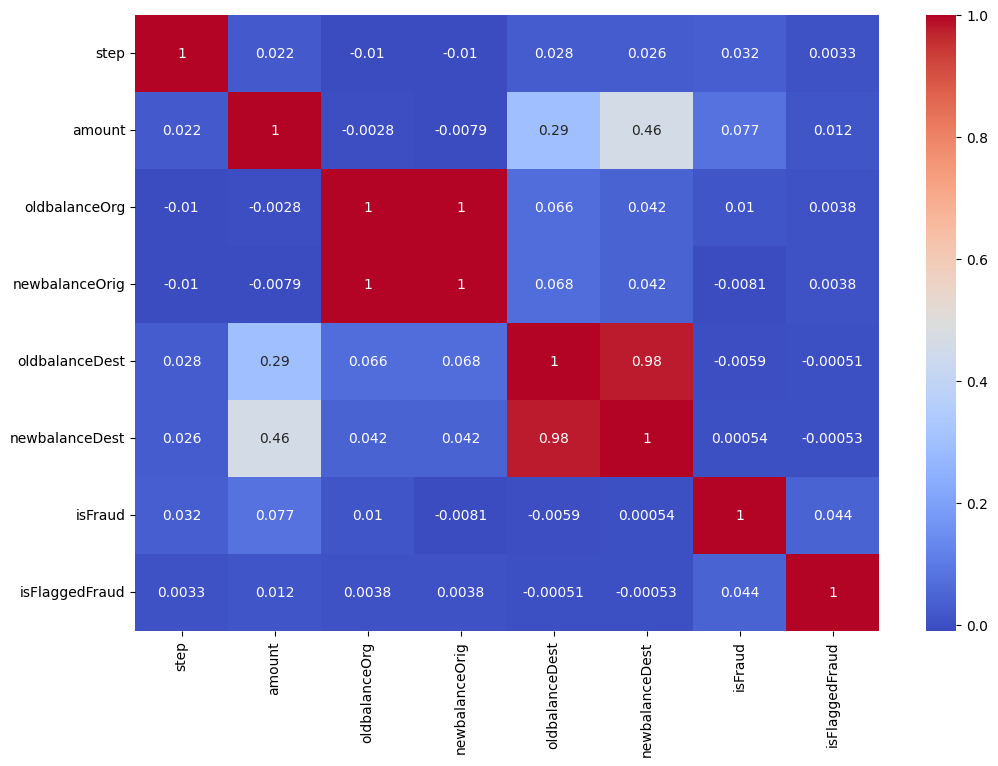

In [8]:
# numeric columns
numeric_columns = df.dtypes[df.dtypes != 'object'].index
correlation = df[list(numeric_columns)].corr()

# correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

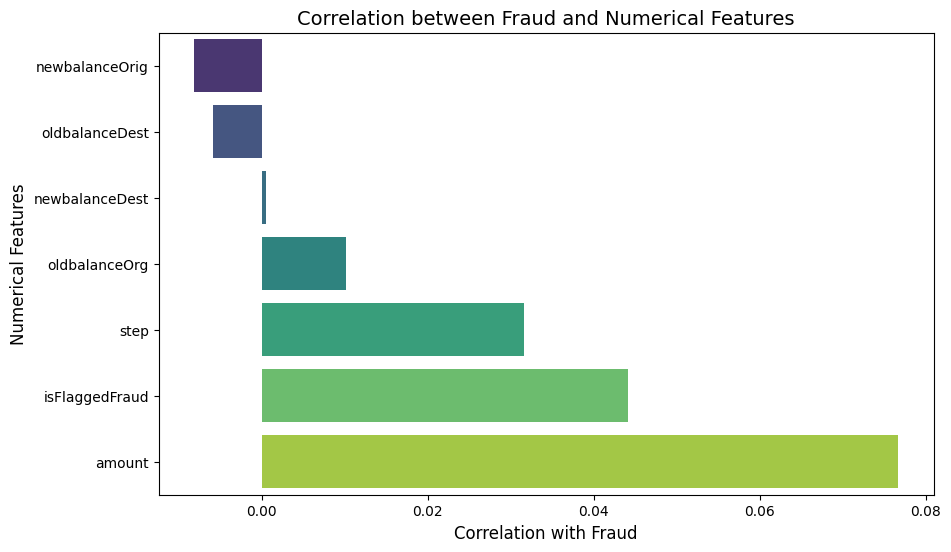

In [9]:
# Select numeric columns only
numeric_columns = df.dtypes[df.dtypes != 'object'].index.tolist()

# Compute correlation matrix
correlation = df[numeric_columns].corr()

# Extract correlation of numeric columns with 'isFraud'
isFraud_corr = correlation['isFraud'].drop('isFraud').sort_values()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=isFraud_corr.values, y=isFraud_corr.index, palette="viridis")

# Customize labels and title
plt.xlabel("Correlation with Fraud", fontsize=12)
plt.ylabel("Numerical Features", fontsize=12)
plt.title("Correlation between Fraud and Numerical Features", fontsize=14)

# Show the plot
plt.show()


### Distribution

- Given the right skewness of `newbalanceDest`, `oldbalanceDest`, `newbalanceOrig`, `oldbalanceOrg` and `amount`, we will do a log transformation to `oldbalanceDest`, `oldbalanceOrg` and `amount` within the feature engineering phase to normalize distributions and enhance model interpretability.

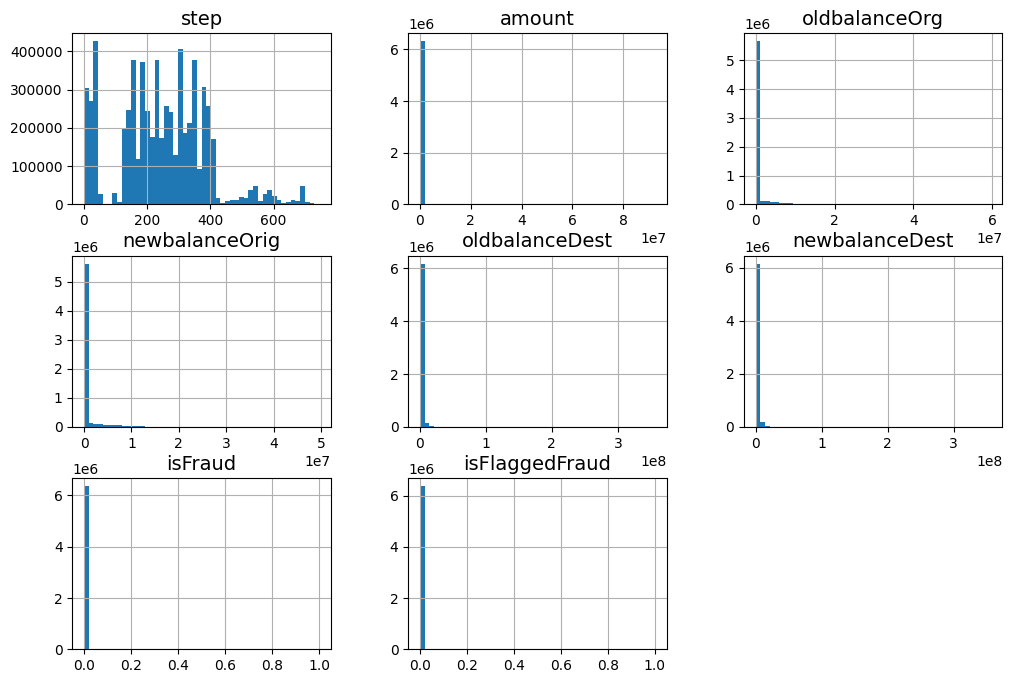

In [11]:
# Visualize the distribution of the numerical columns
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()

### Inspect `isFraud` Column

- The data contains far fewer fraudulent transactions than non fraudulent ones. To mitigate this, undersampling was explored to enhance model performance and reduce bias toward the majority class.

In [12]:
# Count occurrences of each loan status category
transaction_status_counts = df['isFraud'].value_counts()
transaction_status_counts

isFraud
0    6354407
1       8213
Name: count, dtype: int64

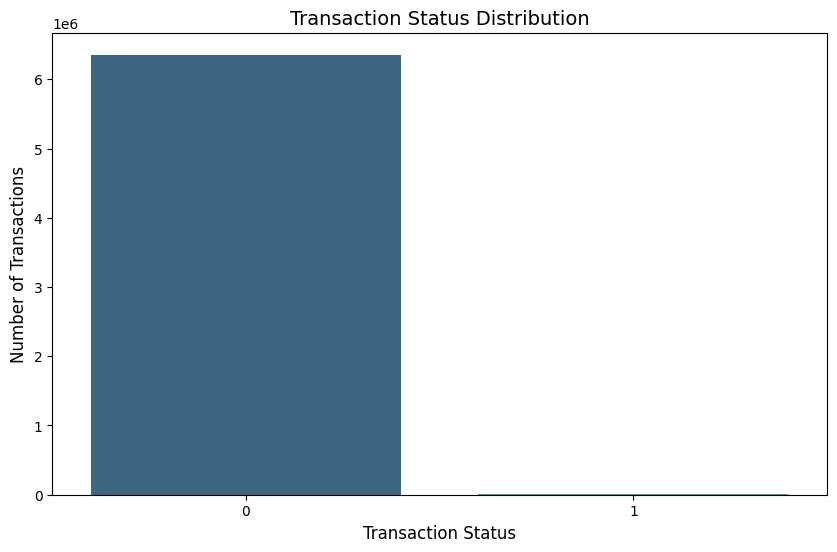

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=transaction_status_counts.index, y=transaction_status_counts.values, palette="viridis")

plt.xlabel("Transaction Status", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.title("Transaction Status Distribution", fontsize=14)

plt.show()

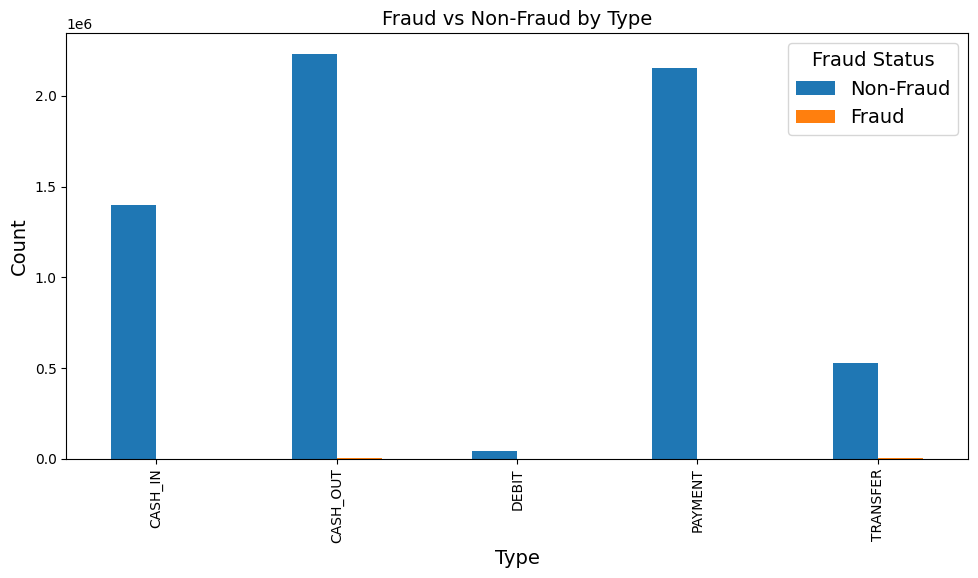

In [14]:
fraud_counts = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0)

# Plotting
ax = fraud_counts.plot(kind='bar', stacked=False, figsize=(10, 6))

# Adding labels and title
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.set_title('Fraud vs Non-Fraud by Type')

# Adding a legend
ax.legend(['Non-Fraud', 'Fraud'], title='Fraud Status')

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
# Fraud and non-fraud subsets
df_fraud = df[df.isFraud == 1]
df_non_fraud = df[df.isFraud == 0]

# Calculate counts
fraud_count = df_fraud.groupby('type').size()
nonfraud_count = df_non_fraud.groupby('type').size()

# Calculate fraud percentage
fraud_percent = df.groupby('type')['isFraud'].mean() * 100

# Combine into one table
summary = pd.concat([fraud_count, nonfraud_count, fraud_percent], axis=1)
summary.columns = ['Fraud Count', 'Non-Fraud Count', 'Fraud (%)']

# Sort by highest fraud percentage
summary = summary.sort_values(by='Fraud (%)', ascending=False)

summary

,Fraud Count,Non-Fraud Count,Fraud (%)
type,,,
TRANSFER,4097.0,528812,0.768799
CASH_OUT,4116.0,2233384,0.183955
CASH_IN,NaN,1399284,0.000000
DEBIT,NaN,41432,0.000000
PAYMENT,NaN,2151495,0.000000


#### Transaction Amount vs Fraud Status

Despite the presence of outliers in the Transaction Amount column they may proof to be significant in fraud detection as anomalies may represent valuable indicators of suspicious activity:

- Exceptionally high transaction amounts often serve as strong indicators of potential fraud. Removing these data points may eliminate critical signals that help the model identify suspicious activities.

- Although many extreme outliers correspond to Fraud Status = 0 (non-fraudulent transactions), a number of high value cases are also labeled as Fraud Status = 1.

- While large fraudulent transactions do not happen often, they can cause major losses, so it is important to keep and detect them during training.

- The smaller number of outliers among fraudulent transactions may also reflect the dataset’s class imbalance, where fraud instances are considerably less common.

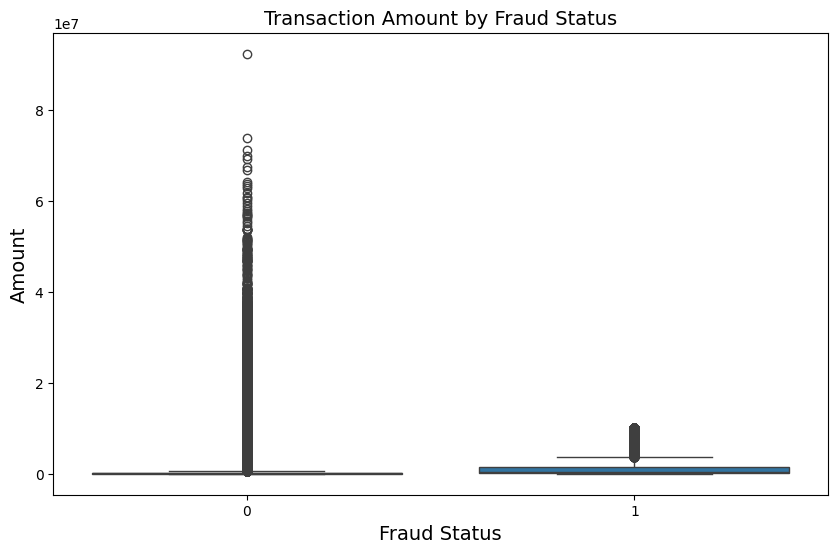

In [16]:
# Boxplot of transaction amount by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Amount')
plt.show()

#### Origin Balance = 0

- Usually in typical financial contexts, if an account’s original balance (oldbalanceOrg) is zero yet a non-zero transaction occurs, it might initially appear suspicious as transactions usually require available funds.

- Our analysis reveals that nearly all transactions with balance inconsistencies, specifically where the origin balance (oldbalanceOrg) is zero, are labeled as non-fraudulent (isFraud = 0), with very few or no cases classified as fraudulent.

- These results indicate that an oldbalanceOrg of zero does not reliably signal fraud. Transactions from zero balances are predominantly legitimate, making this feature more indicative of normal behavior than fraudulent activity.

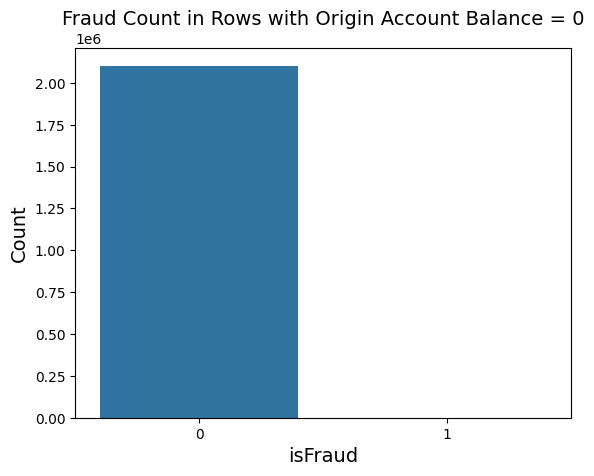

In [17]:
inconsistent_rows = df[df['oldbalanceOrg'] == 0]

sns.countplot(data=inconsistent_rows, x='isFraud')
plt.title('Fraud Count in Rows with Origin Account Balance = 0')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

In [18]:
counts = inconsistent_rows['isFraud'].value_counts()
counts

isFraud
0    2102408
1         41
Name: count, dtype: int64

#### Step vs Fraud Status
- The number of non-fraud cases decreases as steps go by
- The number of fraud cases remain relatively consistent as steps go by

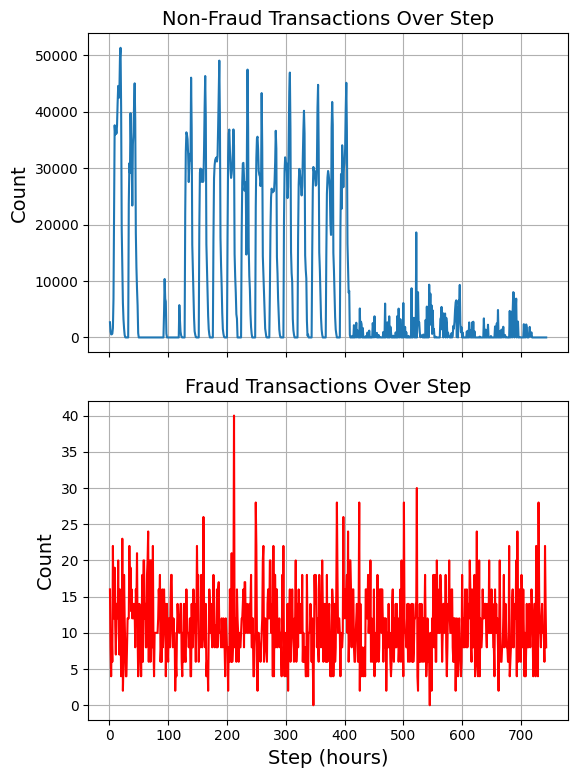

In [19]:
counts = df.groupby(['step', 'isFraud']).size().unstack(fill_value=0)

steps = counts.index
nonfraud = counts[0]
fraud    = counts[1]

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

axes[0].plot(steps, nonfraud)
axes[0].set_title('Non-Fraud Transactions Over Step')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].plot(steps, fraud, color='red')
axes[1].set_title('Fraud Transactions Over Step')
axes[1].set_xlabel('Step (hours)')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Inspect Categorical Columns

#### Transaction Types

In [20]:
# Show unique values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}:", df[col].nunique())

type: 5
nameOrig: 6353307
nameDest: 2722362


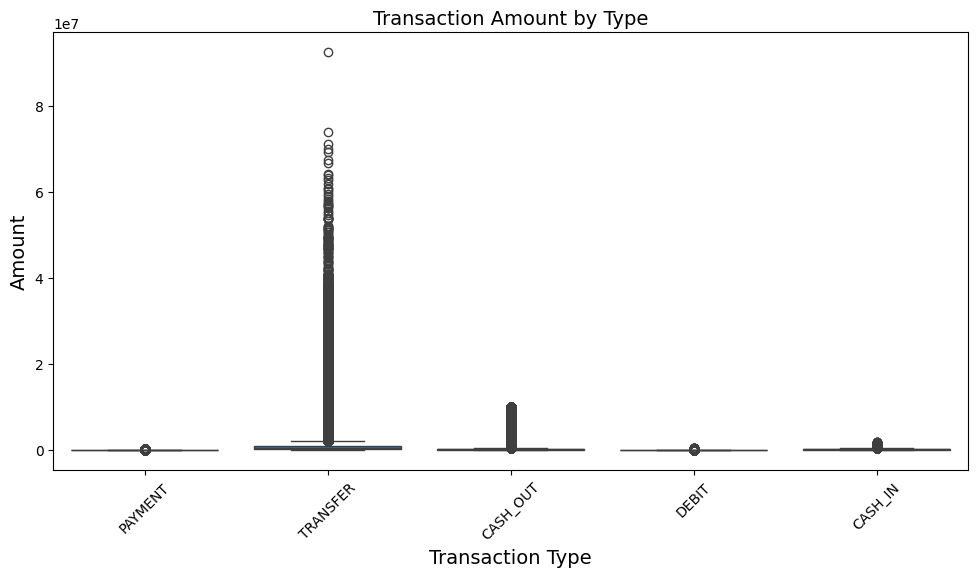

In [21]:
# Boxplot of amount for each transaction type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type', y='amount')
plt.title('Transaction Amount by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preparation

### Split the Data
- We perform the data split before any manipulation to better reflect real-world scenarios, where the model encounters unseen data during deployment.

In [22]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=4012)

In [23]:
X_train = train_set.drop("isFraud", axis=1)
y_train = train_set["isFraud"].copy()
X_test = test_set.drop("isFraud", axis=1)
y_test = test_set["isFraud"].copy()

### Data Cleaning

#### Check Missing Values

In [24]:
X_train.isnull().sum().sort_values(ascending=False)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64

In [25]:
null_rows_idx = X_train.isnull().any(axis=1)
X_train.loc[null_rows_idx].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud


In [26]:
X_train = X_train.copy()
X_test = X_test.copy()

X_train.dropna(subset=["nameOrig","oldbalanceOrg", "newbalanceOrig", "nameDest", "oldbalanceDest", "newbalanceDest"], inplace=True)
X_train.loc[null_rows_idx].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud


#### Check Duplicated Data

In [27]:
# check duplicates in X_train
X_train.duplicated().sum()

0

# Feature Engineering

#### Dropping of columns
1. Drop `isFlaggedFraud`
  - We decided to drop ‘isFlaggedFraud’ as it was an internal flag to pre-label potentially suspicious transactions and was likely not part of the initial raw dataset.

  - Keeping this feature in our model would risk data leakage, since it potentially encodes information about fraud that our model should learn on its own. To allow our model to generalize and prevent reliance on pre-engineered indicators, we will exclude this column.

2. Drop Columns with new

  - Columns containing “new” (such as newbalanceOrig and newbalanceDest) were removed because they are highly correlated to oldBalanceOrg and oldBalanceDest.


In [28]:
# Drop 'isFlaggedFraud' and columns containing 'new' from X_train and X_test
cols_to_drop = [col for col in X_train.columns if 'new' in col] + ['isFlaggedFraud']

X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

## Feature Engineering function

In [29]:
def engineer_features(X, is_train=True):
    """
    COMPREHENSIVE Feature Engineering Function
    
    This function combines ALL feature engineering steps including:
    - Ratio & logarithmic transformations
    - Type-based anomaly features  
    - Balance consistency checks
    - Transaction velocity features (customer patterns)
    - Risk scoring features
    - Transaction pattern features
    - One-hot encoding of transaction types
    
    Parameters:
    - X: Input dataframe with raw features
    - is_train: Boolean indicating if this is training data (learns patterns) or test data
    
    Returns:
    - X: Dataframe with comprehensive engineered features
    """
    global avg_amount_by_type, ohe, customer_stats, dest_stats, hourly_patterns

    X = X.copy()
    
    # === 1. Ratio & Logarithmic Features ===
    # Transaction amount as a proportion of sender's available balance
    X['amount_ratio_org'] = np.where(X['oldbalanceOrg'] != 0,
                                     X['amount'] / X['oldbalanceOrg'],
                                     0)

    # Logarithmic transformation of amount and balances to reduce skewness
    X['log_amount'] = np.log1p(X['amount'])
    X['log_oldbalanceOrg'] = np.log1p(X['oldbalanceOrg'])
    X['log_oldbalanceDest'] = np.log1p(X['oldbalanceDest'])

    # Flag transactions where the destination account starts empty
    X['flag_oldbalanceDest_zero'] = (X['oldbalanceDest'] == 0).astype(int)

    # === 2. Type-Based Anomaly Features ===
    # Learn average transaction amount per type (on training only)
    if is_train:
        avg_amount_by_type = X.groupby('type')['amount'].mean().to_dict()
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        ohe.fit(X[['type']])

    # Ratio of transaction amount to the average for its type
    X['amount_ratio_type'] = X['amount'] / X['type'].map(avg_amount_by_type)
    X['amount_ratio_type'] = X['amount_ratio_type'].fillna(X['amount'].mean())

    # Binary flag for unusually large transactions within type
    X['flag_unusual_amount'] = (X['amount'] > 3 * X['type'].map(avg_amount_by_type)).astype(int)

    # === 3. Balance Consistency Features ===
    # Check if transaction empties account
    X['balance_consistent_orig'] = (
        (X['oldbalanceOrg'] - X['amount']) == 0
    ).astype(int)

    # Check if destination have non-zero balance before transaction
    X['dest_balance_increases'] = (
        X['oldbalanceDest'] > 0
    ).astype(int)

    # === 4. Transaction Velocity Features ===
    # Create customer transaction frequency (proxy using name patterns)
    X['customer_id'] = X['nameOrig'].str.extract('(\d+)').astype(float)
    X['dest_id'] = X['nameDest'].str.extract('(\d+)').astype(float)

    if is_train:
        # Learn customer patterns from training data
        customer_stats = X.groupby('customer_id').agg({
            'amount': ['count', 'mean', 'std', 'max'],
            'step': ['min', 'max']
        }).round(4)
        customer_stats.columns = ['_'.join(col) for col in customer_stats.columns]

        # Learn destination patterns
        dest_stats = X.groupby('dest_id').agg({
            'amount': ['count', 'mean', 'sum'],
            'oldbalanceDest': 'mean'
        }).round(4)
        dest_stats.columns = ['dest_' + '_'.join(col) for col in dest_stats.columns]

        # Learn hourly patterns
        hourly_patterns = X.groupby('step')['amount'].agg(['mean', 'std']).round(4)

    # Merge customer statistics
    X = X.merge(customer_stats, on='customer_id', how='left', suffixes=('', '_cust'))
    X = X.merge(dest_stats, on='dest_id', how='left', suffixes=('', '_dest'))
    X = X.merge(hourly_patterns, on='step', how='left', suffixes=('', '_hourly'))

    # Fill missing values with defaults
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = X[numeric_cols].fillna(0)

    # === 5. Risk Scoring Features ===
    # Transaction size relative to customer's historical average
    X['amount_vs_customer_avg'] = np.where(
        X['amount_mean'] > 0,
        X['amount'] / X['amount_mean'],
        0
    )

    # Transaction size relative to customer's historical maximum
    X['amount_vs_customer_max'] = np.where(
        X['amount_max'] > 0,
        X['amount'] / X['amount_max'],
        0
    )

    # Unusual timing (transaction outside customer's typical hours)
    X['unusual_timing'] = (
        (X['step'] < X['step_min']) |
        (X['step'] > X['step_max'])
    ).astype(int)

    # === 6. Transaction Pattern Features ===
    # Round number amounts (often associated with fraud)
    X['round_amount'] = (X['amount'] % 100 == 0).astype(int)
    X['very_round_amount'] = (X['amount'] % 1000 == 0).astype(int)

    # Account age proxy (difference between current step and first seen)
    X['account_age_proxy'] = X['step'] - X['step_min']

    # Transaction frequency score
    X['high_frequency_customer'] = (X['amount_count'] > X['amount_count'].quantile(0.9)).astype(int)

    # === 7. Advanced Ratio Features ===
    # Destination receiving capacity
    X['dest_receiving_ratio'] = np.where(
        X['dest_amount_sum'] > 0,
        X['amount'] / X['dest_amount_sum'],
        0
    )

    # Transaction concentration (how much of customer's total activity is this transaction)
    X['transaction_concentration'] = np.where(
        X['amount_count'] > 0,
        1 / X['amount_count'],  # Higher value = more concentrated
        1
    )

    # === 8. One-Hot Encode Transaction Type ===
    # Apply one-hot encoding to the 'type' column
    type_encoded = ohe.transform(X[['type']])
    type_df = pd.DataFrame(
        type_encoded, 
        columns=ohe.get_feature_names_out(['type']),
        index=X.index
    )
    
    # Add encoded columns to dataframe
    X = pd.concat([X, type_df], axis=1)
    
    # Drop the original 'type' column and name columns (not needed for modeling)
    X = X.drop(['type', 'nameOrig', 'nameDest', 'customer_id', 'dest_id'], axis=1, errors='ignore')

    return X

In [30]:
# Training
X_train_fe = engineer_features(X_train, is_train=True)

# Testing
X_test_fe = engineer_features(X_test, is_train=False)

In [31]:
print(X_train_fe.columns)
X_train_fe.head()
X_train_fe.info()

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'amount_ratio_org',
       'log_amount', 'log_oldbalanceOrg', 'log_oldbalanceDest',
       'flag_oldbalanceDest_zero', 'amount_ratio_type', 'flag_unusual_amount',
       'balance_consistent_orig', 'dest_balance_increases', 'amount_count',
       'amount_mean', 'amount_std', 'amount_max', 'step_min', 'step_max',
       'dest_amount_count', 'dest_amount_mean', 'dest_amount_sum',
       'dest_oldbalanceDest_mean', 'mean', 'std', 'amount_vs_customer_avg',
       'amount_vs_customer_max', 'unusual_timing', 'round_amount',
       'very_round_amount', 'account_age_proxy', 'high_frequency_customer',
       'dest_receiving_ratio', 'transaction_concentration', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090096 entries, 0 to 5090095
Data columns (total 39 columns):
 #   Column                     Dtype  
---  ------       

In [32]:
print(X_test_fe.columns)
X_test_fe.head()
X_test_fe.info()

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'amount_ratio_org',
       'log_amount', 'log_oldbalanceOrg', 'log_oldbalanceDest',
       'flag_oldbalanceDest_zero', 'amount_ratio_type', 'flag_unusual_amount',
       'balance_consistent_orig', 'dest_balance_increases', 'amount_count',
       'amount_mean', 'amount_std', 'amount_max', 'step_min', 'step_max',
       'dest_amount_count', 'dest_amount_mean', 'dest_amount_sum',
       'dest_oldbalanceDest_mean', 'mean', 'std', 'amount_vs_customer_avg',
       'amount_vs_customer_max', 'unusual_timing', 'round_amount',
       'very_round_amount', 'account_age_proxy', 'high_frequency_customer',
       'dest_receiving_ratio', 'transaction_concentration', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272524 entries, 0 to 1272523
Data columns (total 39 columns):
 #   Column                     Non-Null Count    Dtype  


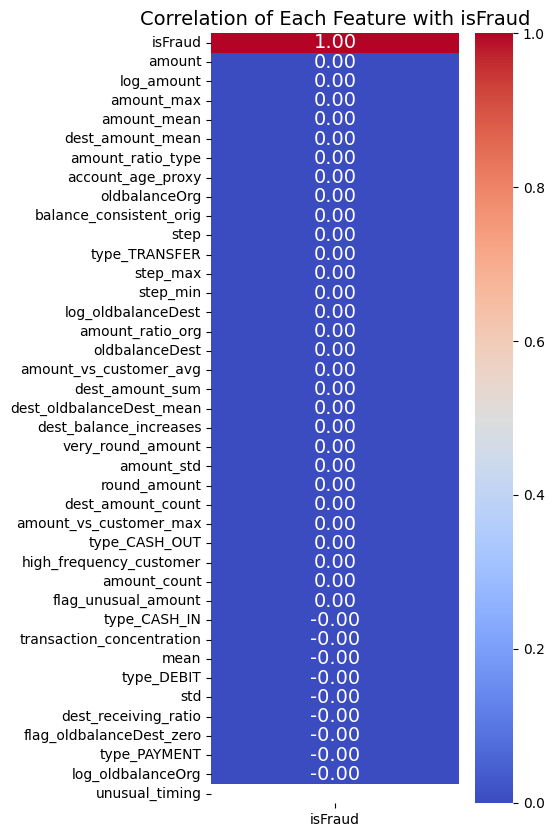

In [33]:
df = pd.concat([X_train_fe, y_train], axis=1)

# Compute correlation matrix
corr_matrix = df.corr()

# Extract only the column corresponding to isFraud
corr_with_fraud = corr_matrix[['isFraud']].sort_values(by='isFraud', ascending=False)

# Plot a single-column heatmap
plt.figure(figsize=(4, 10))
sns.heatmap(corr_with_fraud, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Each Feature with isFraud")
plt.show()


### Exploring distribution

- Evaluating the distribution of fraudulent versus non-fraudulent transactions is essential for developing an effective fraud detection model. Because fraud cases are typically rare, the dataset is often imbalanced, which can cause the model to become biased toward the majority class which is non-fraud. This analysis quantifies the degree of imbalance and supports the use of resampling methods such as downsampling to improve model performance.


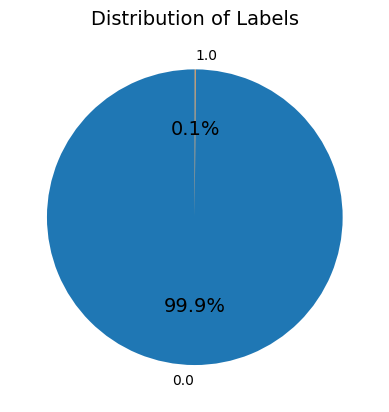

In [40]:
Xy_train = X_train_fe.copy()
Xy_train['isFraud'] = y_train
label_counts = Xy_train['isFraud'].value_counts()
label_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Distribution of Labels')
plt.show()

In [41]:
label_counts

isFraud
0.0    4068771
1.0       3149
Name: count, dtype: int64

After data cleaning, the dataset contains only about 0.1% fraudulent transactions, indicating that the vast majority are non-fraudulent. Such a severe class imbalance can produce misleading results because a model that predicts every transaction as non-fraud would achieve high overall accuracy but completely fail to identify fraud cases, resulting in zero recall. To overcome this issue, we applied class imbalance handling techniques specific to each model. These approaches allowed the models to learn meaningful distinctions between fraud and non-fraud cases, reducing bias toward the majority class and significantly enhancing their fraud detection performance.

# Models

## 1. Logistic Regression Model

In [37]:
# 1. Calculate VIF and remove multicollinear features
scaler = StandardScaler()
X_scaled_for_vif = scaler.fit_transform(X_train_fe)

vif_df = pd.DataFrame()
vif_df["feature"] = X_train_fe.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled_for_vif, i) for i in range(X_scaled_for_vif.shape[1])]
high_vif_features = vif_df[vif_df["VIF"] > 10]["feature"].tolist()
print("Dropping high-VIF features:", high_vif_features)

X_train_vif_reduced = X_train_fe.drop(columns=high_vif_features)
X_test_vif_reduced = X_test_fe.drop(columns=high_vif_features)

# 2. Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vif_reduced)
X_test_scaled = scaler.transform(X_test_vif_reduced)

# 3. Define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=0.1, random_state=4012)

# 4. Define logistic regression and pipeline
logreg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    solver='liblinear'  # supports both l1 and l2
)

pipeline = Pipeline([
    ('undersample', undersample),
    ('logistic', logreg)
])

# 5. Hyperparameter grid
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2'],
    'logistic__class_weight': [None, 'balanced', {0: 0.6, 1: 0.4}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4012)

# 6. Randomized Search with Cross-Validation
model_cv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

model_cv.fit(X_train_scaled, y_train)
print("Best Parameters:", model_cv.best_params_)

Dropping high-VIF features: ['step', 'amount', 'log_oldbalanceDest', 'flag_oldbalanceDest_zero', 'dest_balance_increases', 'amount_count', 'amount_mean', 'amount_std', 'amount_max', 'step_min', 'step_max', 'amount_vs_customer_max', 'account_age_proxy', 'high_frequency_customer', 'transaction_concentration', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


python(11682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


python(11683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11689) Malloc

Best Parameters: {'logistic__penalty': 'l1', 'logistic__class_weight': None, 'logistic__C': 1}


In [38]:
# 6. Evaluation on test set
y_pred = model_cv.predict(X_test_scaled)
y_proba = model_cv.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270884
           1       0.99      0.98      0.99      1640

    accuracy                           1.00   1272524
   macro avg       0.99      0.99      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524

Accuracy: 0.9999622796898133
Precision: 0.985958485958486
Precision: 0.985958485958486
Recall: 0.9847560975609756
Recall: 0.9847560975609756
F1 Score: 0.9853569249542404
F1 Score: 0.9853569249542404
ROC AUC Score: 0.9975822273814248
ROC AUC Score: 0.9975822273814248


### Feature Importance

In [39]:
# 7. Interpret coefficients and compute odds ratios
feature_names = X_train_vif_reduced.columns.tolist()

# Get coefficients from logistic step
coefs = model_cv.best_estimator_.named_steps['logistic'].coef_[0]

# Build feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Odds Ratio': np.exp(coefs)
}).sort_values(by='Odds Ratio', ascending=False)

# Show top 10
print(importance_df.head(10))

                    Feature  Coefficient  Odds Ratio
7   balance_consistent_orig     4.220859   68.091919
8         dest_amount_count     1.007470    2.738663
0             oldbalanceOrg     0.429664    1.536741
5         amount_ratio_type     0.412507    1.510600
12                     mean     0.360478    1.434015
3                log_amount     0.269607    1.309450
9          dest_amount_mean     0.229875    1.258443
17        very_round_amount     0.096408    1.101208
10          dest_amount_sum     0.081339    1.084739
16             round_amount     0.045295    1.046337


## 2. LightGBM Model

In [40]:
# 1. Handle class imbalance via scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 2. Define Optuna objective function
def objective_lgb(trial):
    # Suggest hyperparameters
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [4, 6, 8]),
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 63, 127]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100, step=10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 4012,
        'n_jobs': 1,
        'verbosity': -1
    }

    model = LGBMClassifier(**params)

    # 3. Stratified CV
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=4012)
    scores = cross_val_score(model, X_train_fe, y_train, cv=cv, scoring='roc_auc', n_jobs=1)

    # Return mean ROC AUC
    return np.mean(scores)

# 4. Create Optuna study
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=20)

# 5. Best hyperparameters
print("Best Parameters:", study_lgb.best_params)
print("Best CV ROC AUC Score:", study_lgb.best_value)

# 6. Dictionary to store best params for all models
all_best_params = {}
all_best_params['LGBM'] = study_lgb.best_params

# 7. Train final model on full training data
best_lgb_model = LGBMClassifier(**study_lgb.best_params,
                                scale_pos_weight=scale_pos_weight,
                                random_state=4012,
                                n_jobs=1,
                                verbosity=-1)
best_lgb_model.fit(X_train_fe, y_train)

# 8. Align test set
X_test_fe = X_test_fe[X_train_fe.columns]


[I 2025-11-13 10:13:55,518] A new study created in memory with name: no-name-cf6c3cb5-1482-47b9-8753-cb8c14634407
[I 2025-11-13 10:16:27,544] Trial 0 finished with value: 0.9989257881236113 and parameters: {'max_depth': 8, 'num_leaves': 127, 'learning_rate': 0.024840584135436293, 'min_child_samples': 20, 'subsample': 0.9312882539732128, 'colsample_bytree': 0.8478346215173486, 'reg_alpha': 0.7551642807895513, 'reg_lambda': 0.9766872043654677}. Best is trial 0 with value: 0.9989257881236113.
[I 2025-11-13 10:16:27,544] Trial 0 finished with value: 0.9989257881236113 and parameters: {'max_depth': 8, 'num_leaves': 127, 'learning_rate': 0.024840584135436293, 'min_child_samples': 20, 'subsample': 0.9312882539732128, 'colsample_bytree': 0.8478346215173486, 'reg_alpha': 0.7551642807895513, 'reg_lambda': 0.9766872043654677}. Best is trial 0 with value: 0.9989257881236113.
[I 2025-11-13 10:18:25,076] Trial 1 finished with value: 0.9994239607512185 and parameters: {'max_depth': 4, 'num_leaves': 6

Best Parameters: {'max_depth': 4, 'num_leaves': 63, 'learning_rate': 0.010031544110816006, 'min_child_samples': 20, 'subsample': 0.7095247382672005, 'colsample_bytree': 0.6171742437473005, 'reg_alpha': 0.9921374388215032, 'reg_lambda': 0.7479950425502517}
Best CV ROC AUC Score: 0.9997544716207486


In [41]:
# 9. Evaluate on test set
y_pred  = best_lgb_model.predict(X_test_fe)
y_proba = best_lgb_model.predict_proba(X_test_fe)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270884
           1       0.98      0.99      0.98      1640

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524

Accuracy: 0.9999607080102222
Precision: 0.9783393501805054
Precision: 0.9783393501805054
Recall: 0.9914634146341463
Recall: 0.9914634146341463
F1 Score: 0.9848576620230164
F1 Score: 0.9848576620230164
ROC AUC Score: 0.9991513682602031
ROC AUC Score: 0.9991513682602031


### Feature Importance

In [42]:
# 10. Feature importances
importances = pd.DataFrame({
    'feature':   X_train_fe.columns,
    'importance': best_lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top 10 Most Important Features:")
print(importances.head(10))

Top 10 Most Important Features:
                    feature  importance
4          amount_ratio_org         165
2             oldbalanceOrg          73
34             type_CASH_IN          61
37             type_PAYMENT          60
3            oldbalanceDest          51
18                 step_max          51
19        dest_amount_count          40
6         log_oldbalanceOrg          37
11  balance_consistent_orig          32
23                     mean          27


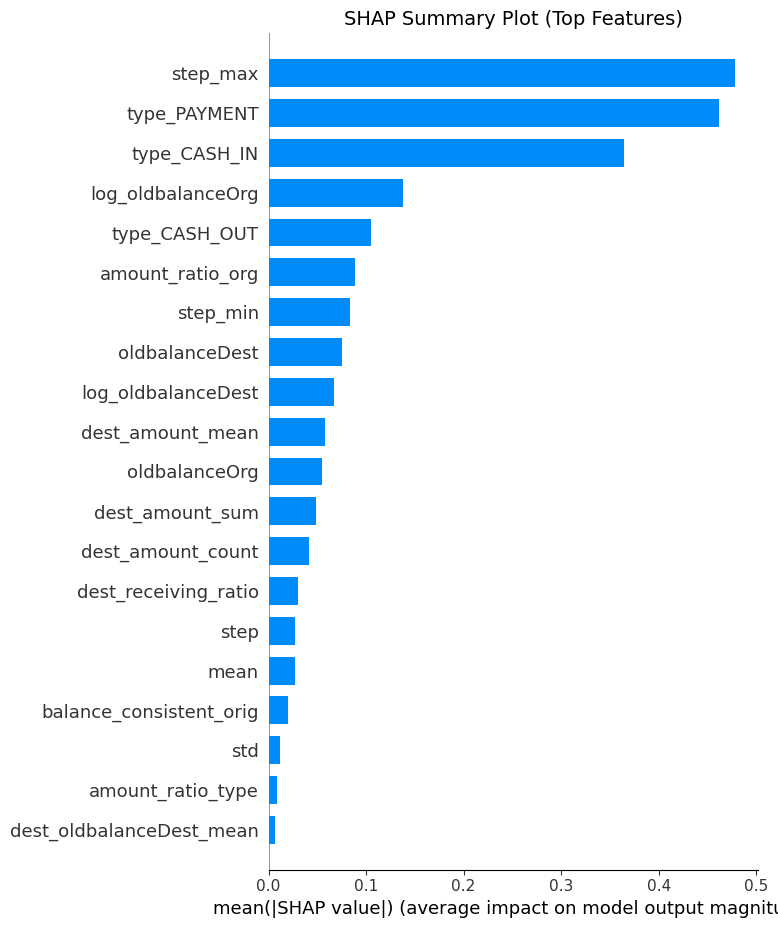

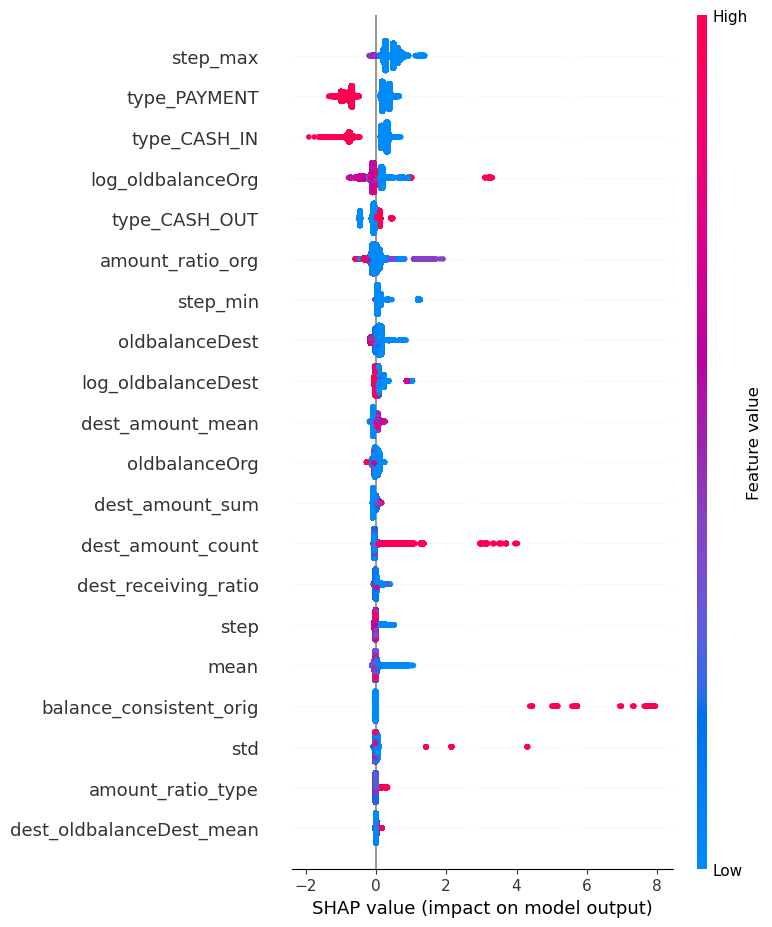

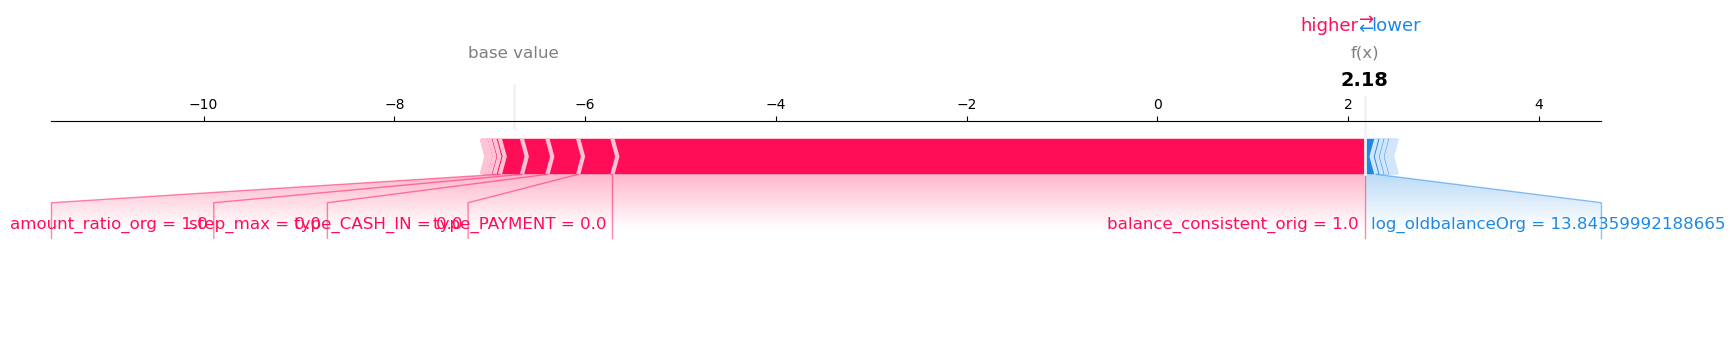

In [43]:
np.random.seed(4012)
explainer  = shap.TreeExplainer(best_lgb_model)
shap_values = explainer.shap_values(X_test_fe)

# 11a. Global summary (bar)
plt.title("SHAP Summary Plot (Top Features)")
shap.summary_plot(shap_values, X_test_fe, plot_type="bar", show=True)

# 11b. Detailed summary (beeswarm)
shap.summary_plot(shap_values, X_test_fe, show=True)

# 11c. Local explanation on the first correctly predicted fraud
fraud_idxs = np.where((y_test == 1) & (y_pred == 1))[0]
if len(fraud_idxs):
    idx = sorted(fraud_idxs)[0]
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_test_fe.iloc[idx],
        matplotlib=True
    )
else:
    print(" No fraud cases predicted in test set to explain.")

## 3. XGBoost Model

In [44]:
# 1. Handle class imbalance via scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 2. Define the Optuna objective function
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [4, 6]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3]),
        'gamma': trial.suggest_categorical('gamma', [0, 0.5]),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'subsample': trial.suggest_categorical('subsample', [0.8]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.8]),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 4012,
        'n_jobs': 1,
        'use_label_encoder': False,
        'verbosity': 0,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=4012)
    scores = cross_val_score(model, X_train_fe, y_train, cv=cv, scoring='roc_auc', n_jobs=1)

    return np.mean(scores)

# 3. Create and run the Optuna study
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

# 4. Best hyperparameters
print("Best Parameters:", study_xgb.best_params)
print("Best CV ROC AUC Score:", study_xgb.best_value)

# 5. Dictionary to store best params for all models
all_best_params = {}
all_best_params['XGB'] = study_xgb.best_params

# 6. Train final model on full training data
best_xgb_model = XGBClassifier(**study_xgb.best_params)
best_xgb_model.fit(X_train_fe, y_train)

# 7. Align test set
X_test_fe = X_test_fe[X_train_fe.columns]

[I 2025-11-13 11:06:56,675] A new study created in memory with name: no-name-7cfc4667-65c4-4a30-a0bd-b0397bac746e
[I 2025-11-13 11:09:22,742] Trial 0 finished with value: 0.9997323532170888 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0, 'learning_rate': 0.09318096443125606, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.9997323532170888.
[I 2025-11-13 11:09:22,742] Trial 0 finished with value: 0.9997323532170888 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'gamma': 0, 'learning_rate': 0.09318096443125606, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.9997323532170888.
[I 2025-11-13 11:11:26,835] Trial 1 finished with value: 0.9997534081200649 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0, 'learning_rate': 0.06652561687496518, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.9997534081200649.
[I 2025-11-13 11:11:26,835] Trial 1 finished with value: 0.99975

Best Parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.5, 'learning_rate': 0.07577883424000284, 'subsample': 0.8, 'colsample_bytree': 0.8}
Best CV ROC AUC Score: 0.9998060046302928


In [45]:
# 8. Evaluate on test set
y_pred  = best_xgb_model.predict(X_test_fe)
y_proba = best_xgb_model.predict_proba(X_test_fe)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270884
           1       1.00      0.97      0.99      1640

    accuracy                           1.00   1272524
   macro avg       1.00      0.99      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524

Accuracy: 0.9999662088887911
Precision: 1.0
Precision: 1.0
Recall: 0.973780487804878
Recall: 0.973780487804878
F1 Score: 0.98671609514983
F1 Score: 0.98671609514983
ROC AUC Score: 0.9986363580053861
ROC AUC Score: 0.9986363580053861


### Feature Importance

In [46]:
# 9. Feature importances
importances = pd.DataFrame({
    'feature':   X_train_fe.columns,
    'importance': best_xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top 10 Most Important Features:")
print(importances.head(10))

Top 10 Most Important Features:
                     feature  importance
11   balance_consistent_orig    0.999543
28              round_amount    0.000149
32      dest_receiving_ratio    0.000100
12    dest_balance_increases    0.000067
29         very_round_amount    0.000044
22  dest_oldbalanceDest_mean    0.000027
8   flag_oldbalanceDest_zero    0.000017
9          amount_ratio_type    0.000008
1                     amount    0.000007
5                 log_amount    0.000006


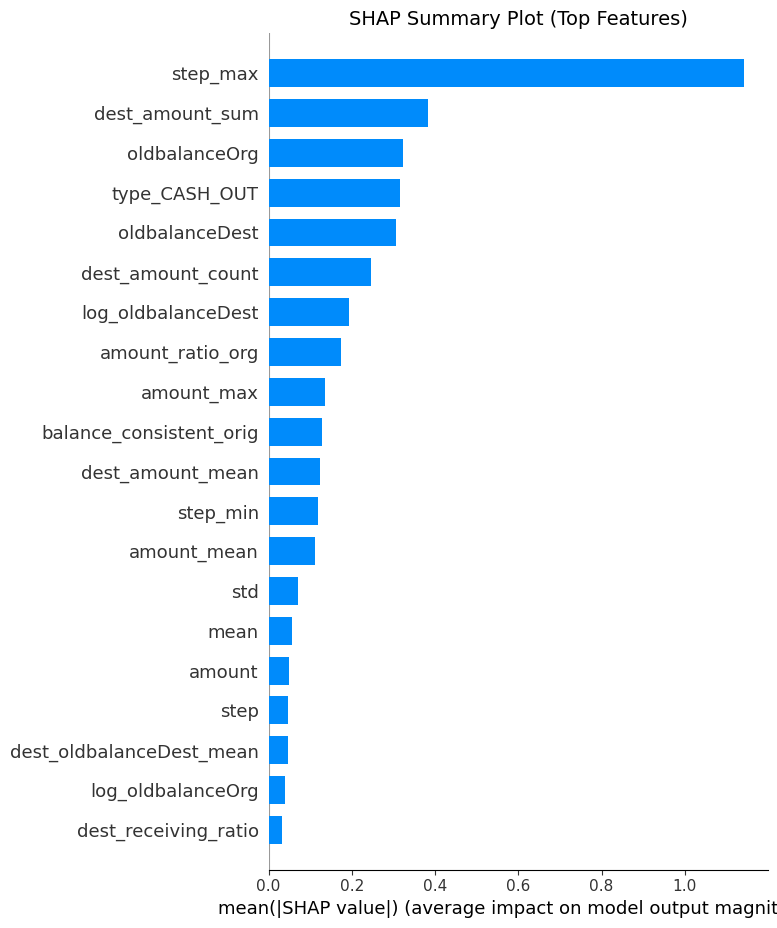

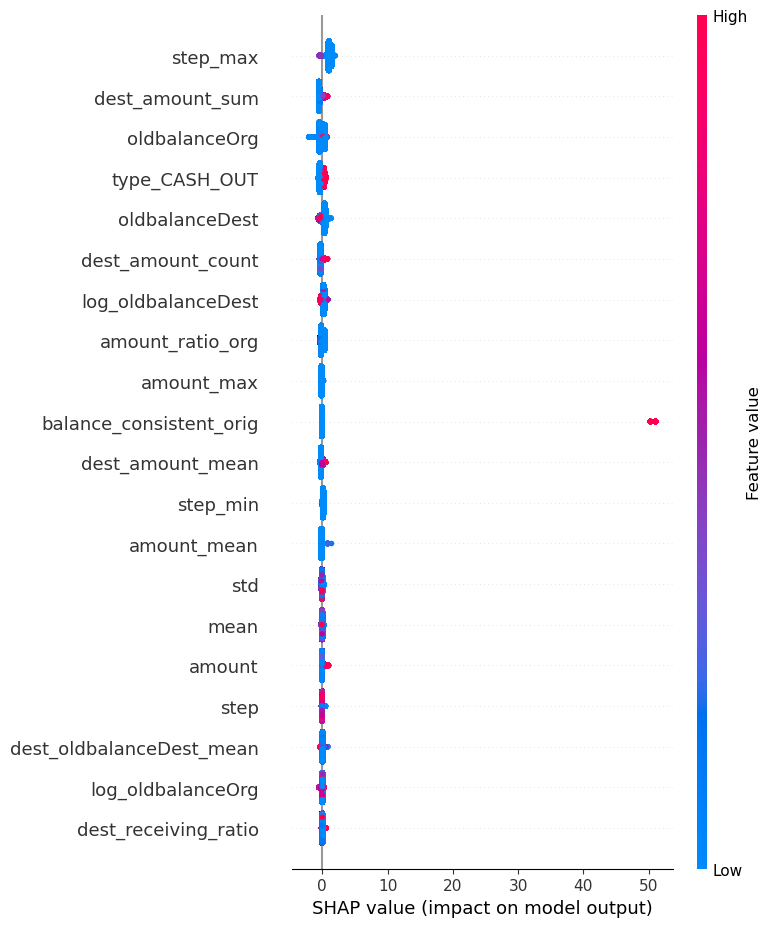

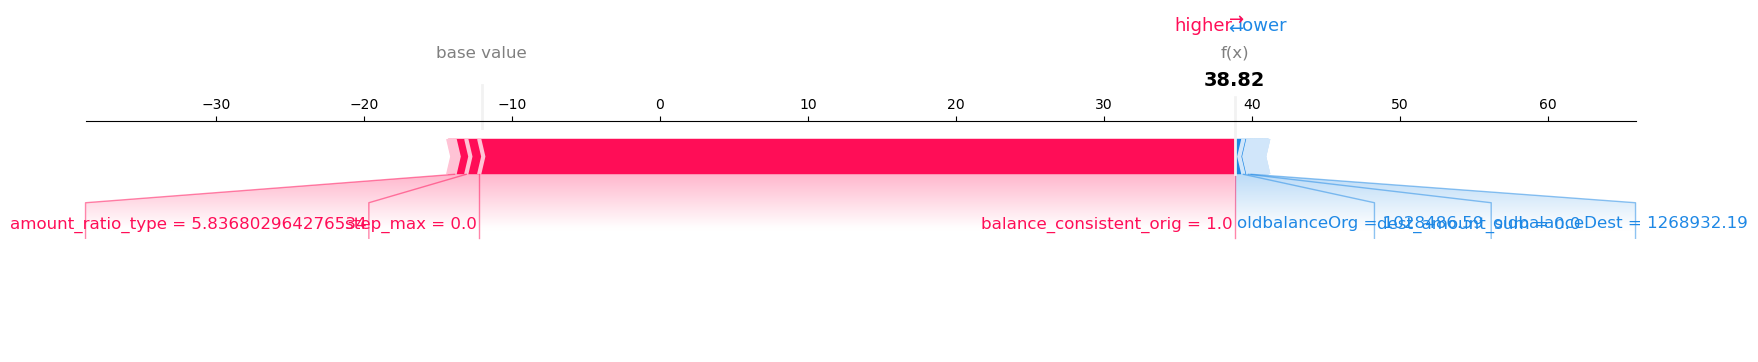

In [47]:
np.random.seed(4012)
explainer  = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_fe)

# 10a. Global summary (bar)
plt.title("SHAP Summary Plot (Top Features)")
shap.summary_plot(shap_values, X_test_fe, plot_type="bar", show=True)

# 10b. Detailed summary (beeswarm)
shap.summary_plot(shap_values, X_test_fe, show=True)

# 10c. Local explanation on the first correctly predicted fraud
fraud_idxs = np.where((y_test == 1) & (y_pred == 1))[0]
if len(fraud_idxs):
    idx = sorted(fraud_idxs)[0]
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_test_fe.iloc[idx],
        matplotlib=True
    )
else:
    print(" No fraud cases predicted in test set to explain.")

## 4. Random Forest Model

In [48]:
# 1. Cross-validation strategy
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=4012)

# 2. Define Optuna objective function
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200]),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'class_weight': 'balanced',
        'random_state': 4012,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)

    scores = cross_val_score(model, X_train_fe, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    return np.mean(scores)

# 3. Create and run Optuna study
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)

# 4. Best hyperparameters
print("Best Parameters:", study_rf.best_params)
print("Best CV ROC AUC Score:", study_rf.best_value)

# 5. Dictionary to store best params for all models
all_best_params = {}
all_best_params['RF'] = study_rf.best_params

# 6. Train final model on full training data
best_rf_model = RandomForestClassifier(**study_rf.best_params)
best_rf_model.fit(X_train_fe, y_train)

# 7. Align test set columns
X_test_fe = X_test_fe[X_train_fe.columns]


[I 2025-11-13 11:59:53,066] A new study created in memory with name: no-name-403b3241-5b8f-4b70-9306-a6c56e5954a4
python(14394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
pyth

Best Parameters: {'n_estimators': 200, 'max_depth': 10}
Best CV ROC AUC Score: 0.9995872326489731


In [49]:
# 8. Predict and evaluate on test set
y_pred = best_rf_model.predict(X_test_fe)
y_proba = best_rf_model.predict_proba(X_test_fe)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270884
           1       1.00      0.99      1.00      1640

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

Accuracy: 0.9999889982428622
Precision: 1.0
Precision: 1.0
Recall: 0.9914634146341463
Recall: 0.9914634146341463
F1 Score: 0.9957134109001837
F1 Score: 0.9957134109001837
ROC AUC Score: 0.9961540808813621
ROC AUC Score: 0.9961540808813621


### Feature Importance

In [50]:
# 9. Feature importance
importances = pd.DataFrame({
    'feature': X_train_fe.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top 10 Most Important Features:")
print(importances.head(10))

Top 10 Most Important Features:
                    feature  importance
11  balance_consistent_orig    0.621332
23                     mean    0.109577
4          amount_ratio_org    0.052506
6         log_oldbalanceOrg    0.046174
2             oldbalanceOrg    0.034489
24                      std    0.031883
35            type_CASH_OUT    0.009975
9         amount_ratio_type    0.009499
18                 step_max    0.009340
17                 step_min    0.008774


 97%|=================== | 1945/2000 [00:19<00:00]       

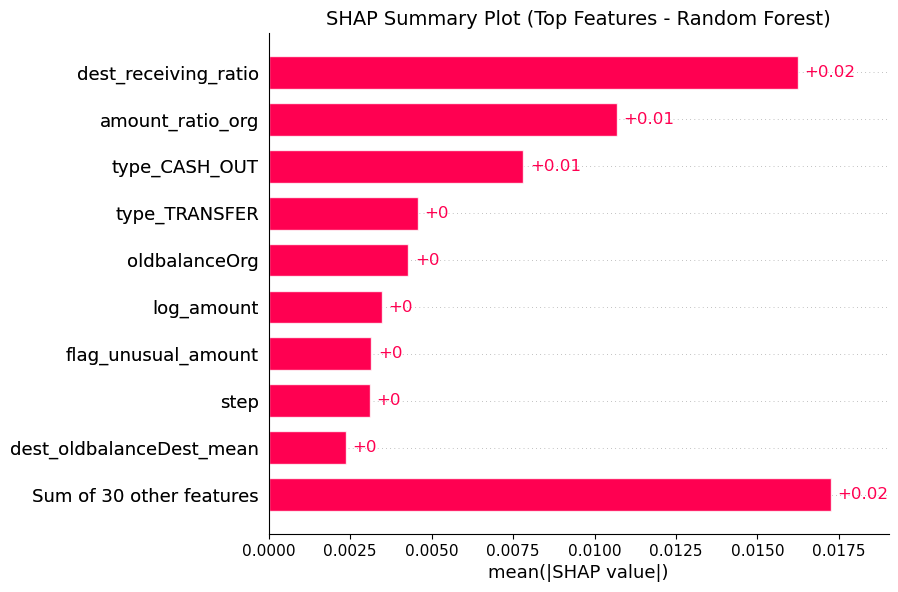

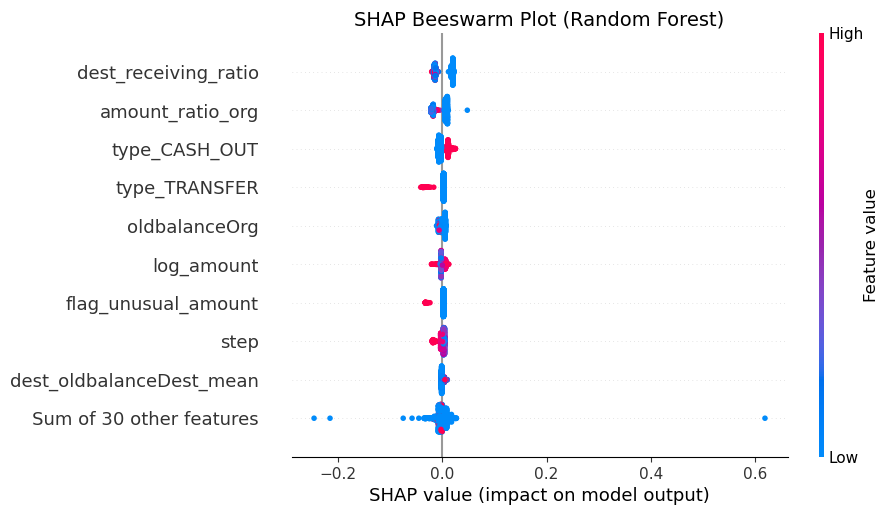

In [51]:
np.random.seed(4012)

X_shap_sample = X_test_fe.sample(n=1000, random_state=4012)

# Create SHAP explainer
explainer = shap.Explainer(best_rf_model, X_shap_sample)
shap_values = explainer(X_shap_sample)

# Extract class 1 SHAP values if output is multi-class
if shap_values.values.ndim == 3:
    shap_values = shap_values[..., 1]  # focus on class 1 (fraud)

# Global summary (bar)
plt.title("SHAP Summary Plot (Top Features - Random Forest)")
shap.plots.bar(shap_values, max_display=10, show=True)

# Detailed summary (beeswarm)
plt.title("SHAP Beeswarm Plot (Random Forest)")
shap.plots.beeswarm(shap_values, max_display=10, show=True)

# Local explanation for a correctly predicted fraud
fraud_idxs = np.where((y_test == 1) & (y_pred == 1))[0]
if len(fraud_idxs):
    idx = sorted(fraud_idxs)[0]
    shap.initjs()
    single_explanation = explainer(X_test_fe.iloc[[idx]])
    shap.plots.force(single_explanation[..., 1][0])  # class 1
else:
    print("No fraud cases predicted in test set to explain.")


## 5. Ensemble Model (Voting Classifier)

Combining all 4 models to leverage their collective strengths through soft voting (averaging probabilities).

In [52]:
from sklearn.ensemble import VotingClassifier

print("Creating Ensemble Voting Classifier...")
print("Combining: Logistic Regression, LightGBM, XGBoost, and Random Forest")
print()

# Create the voting ensemble with soft voting (averages predicted probabilities)
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', model_cv.best_estimator_),  # Logistic Regression pipeline
        ('lgb', best_lgb_model),                # LightGBM
        ('xgb', best_xgb_model),                # XGBoost
        ('rf', best_rf_model)                   # Random Forest
    ],
    voting='soft',  # Use probability averaging for better calibration
    n_jobs=-1
)

# Note: The ensemble will automatically handle different input requirements
# The logistic regression is wrapped in a pipeline that scales data internally
# while tree models use the feature-engineered data directly

print("Training ensemble model")
# Train on feature-engineered data (pipeline will handle scaling for LogReg internally)
ensemble_model.fit(X_train_fe, y_train)

print(" Ensemble model trained successfully!")

Creating Ensemble Voting Classifier...
Combining: Logistic Regression, LightGBM, XGBoost, and Random Forest

Training ensemble model


python(18753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18755) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18755) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(18758) Malloc

 Ensemble model trained successfully!


In [53]:
# Evaluate the ensemble model
print("Evaluating Ensemble Model on Test Set:")
print()

y_pred_ensemble = ensemble_model.predict(X_test_fe)
y_proba_ensemble = ensemble_model.predict_proba(X_test_fe)[:, 1]

# Print comprehensive metrics
print("="*60)
print("ENSEMBLE MODEL PERFORMANCE")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print(conf_matrix)

print("\nKey Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_ensemble):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_ensemble):.4f}")

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

print("\n" + "="*60)

Evaluating Ensemble Model on Test Set:

ENSEMBLE MODEL PERFORMANCE

Classification Report:
ENSEMBLE MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270884
           1       1.00      0.98      0.99      1640

    accuracy                           1.00   1272524
   macro avg       1.00      0.99      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270884
           1       1.00      0.98      0.99      1640

    accuracy                           1.00   1272524
   macro avg       1.00      0.99      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
[[1270884       0]
 [     29    1611]]

Key Metrics:
Accuracy:  1.0000
[[1270884       0]
 [     29    1611]]

Key Metrics:
Accuracy:  1.0000
Precision: 1.0000
Precis

In [54]:
def evaluate_model_comprehensive(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with multiple metrics and visualizations
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

    # Additional fraud-specific metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    metrics.update({
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'NPV': tn / (tn + fn) if (tn + fn) > 0 else 0,
        'False_Positive_Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'False_Negative_Rate': fn / (fn + tp) if (fn + tp) > 0 else 0
    })

    # Cost-based evaluation (assuming cost of missing fraud is 10x cost of false alarm)
    cost_fp = 1  # Cost of false positive
    cost_fn = 10  # Cost of false negative (missing fraud)
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    metrics['Total_Cost'] = total_cost
    metrics['Cost_per_Transaction'] = total_cost / len(y_test)

    return metrics

def plot_roc_curves(models_dict, X_test, y_test):
    """
    Plot ROC curves for multiple models
    """
    plt.figure(figsize=(10, 8))

    for model_name, model in models_dict.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_precision_recall_curves(models_dict, X_test, y_test):
    """
    Plot Precision-Recall curves for multiple models
    """
    plt.figure(figsize=(10, 8))

    for model_name, model in models_dict.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        avg_precision = average_precision_score(y_test, y_proba)

        plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.4f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_threshold_impact(model, X_test, y_test, model_name="Model"):
    """
    Analyze the impact of different probability thresholds on model performance
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.1, 1.0, 0.1)

    results = []
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)

        if len(np.unique(y_pred_thresh)) > 1:  # Ensure both classes are predicted
            precision = precision_score(y_test, y_pred_thresh, zero_division=0)
            recall = recall_score(y_test, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
        else:
            precision = recall = f1 = 0

        results.append({
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

    results_df = pd.DataFrame(results)

    # Plot threshold analysis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(results_df['Threshold'], results_df['Precision'], 'b-', marker='o')
    axes[0].set_title('Precision vs Threshold')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Precision')
    axes[0].grid(True)

    axes[1].plot(results_df['Threshold'], results_df['Recall'], 'r-', marker='o')
    axes[1].set_title('Recall vs Threshold')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Recall')
    axes[1].grid(True)

    axes[2].plot(results_df['Threshold'], results_df['F1'], 'g-', marker='o')
    axes[2].set_title('F1 Score vs Threshold')
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('F1 Score')
    axes[2].grid(True)

    plt.suptitle(f'Threshold Analysis for {model_name}')
    plt.tight_layout()
    plt.show()

    return results_df

In [56]:
# Store all models for comparison (including the ensemble)
models_dict = {
    'Logistic Regression': model_cv.best_estimator_,
    'LightGBM': best_lgb_model,
    'XGBoost': best_xgb_model,
    'Random Forest': best_rf_model,
    'Ensemble (Voting)': ensemble_model
}

# Evaluate all models comprehensively
comparison_results = []

for model_name, model in models_dict.items():
    print(f"\nEvaluating {model_name}...")

    # Handle different data requirements for logistic regression
    if model_name == 'Logistic Regression':
        # Use VIF-reduced and scaled data for logistic regression
        X_test_eval = X_test_scaled
    else:
        # Use feature-engineered data for tree-based models
        # Ensure we use the same features that were used during training
        if hasattr(model, 'feature_names_in_'):
            # Model has feature names - use only those columns
            missing_cols = set(model.feature_names_in_) - set(X_test_fe.columns)
            if missing_cols:
                print(f"   Warning: Missing columns {missing_cols}. You may need to re-run feature engineering (cell 53).")
                print(f"   Attempting to use available columns...")
            common_cols = [col for col in model.feature_names_in_ if col in X_test_fe.columns]
            X_test_eval = X_test_fe[common_cols]
        else:
            # For models without feature_names_in_, try to match training columns
            # Check if X_train_fe columns match
            if set(X_train_fe.columns) == set(X_test_fe.columns):
                X_test_eval = X_test_fe[X_train_fe.columns]
            else:
                print(f"   Warning: Feature mismatch detected.")
                print(f"   Training had {len(X_train_fe.columns)} features, test has {len(X_test_fe.columns)} features.")
                print(f"   Please re-train the {model_name} model after running cell 53.")
                continue  # Skip this model

    # Evaluate model
    try:
        metrics = evaluate_model_comprehensive(model, X_test_eval, y_test, model_name)
        comparison_results.append(metrics)
    except Exception as e:
        print(f"   Error evaluating {model_name}: {str(e)}")
        print(f"   This model needs to be re-trained with the current features.")
        continue

# Create comparison DataFrame
if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(comparison_df.round(4))
else:
    print("\n" + "="*80)
    print(" WARNING: No models could be evaluated!")
    print("="*80)
    print("The models were trained with different features than currently available.")
    print("="*80)


Evaluating Logistic Regression...

Evaluating LightGBM...

Evaluating LightGBM...

Evaluating XGBoost...

Evaluating XGBoost...

Evaluating Random Forest...

Evaluating Random Forest...

Evaluating Ensemble (Voting)...

Evaluating Ensemble (Voting)...

MODEL PERFORMANCE COMPARISON
                 Model  Accuracy  Precision  Recall      F1  ROC-AUC  \
0  Logistic Regression       1.0     0.9860  0.9848  0.9854   0.9976   
1             LightGBM       1.0     0.9783  0.9915  0.9849   0.9992   
2              XGBoost       1.0     1.0000  0.9738  0.9867   0.9986   
3        Random Forest       1.0     1.0000  0.9915  0.9957   0.9962   
4    Ensemble (Voting)       1.0     1.0000  0.9823  0.9911   0.9979   

   Specificity  NPV  False_Positive_Rate  False_Negative_Rate  Total_Cost  \
0          1.0  1.0                  0.0               0.0152         273   
1          1.0  1.0                  0.0               0.0085         176   
2          1.0  1.0                  0.0             


Generating ROC Curves...


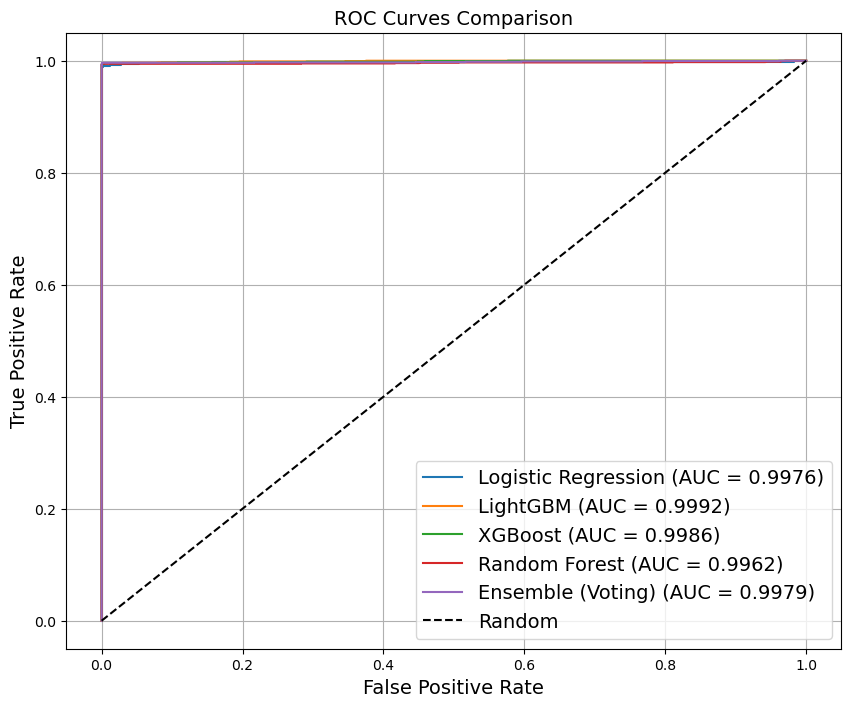

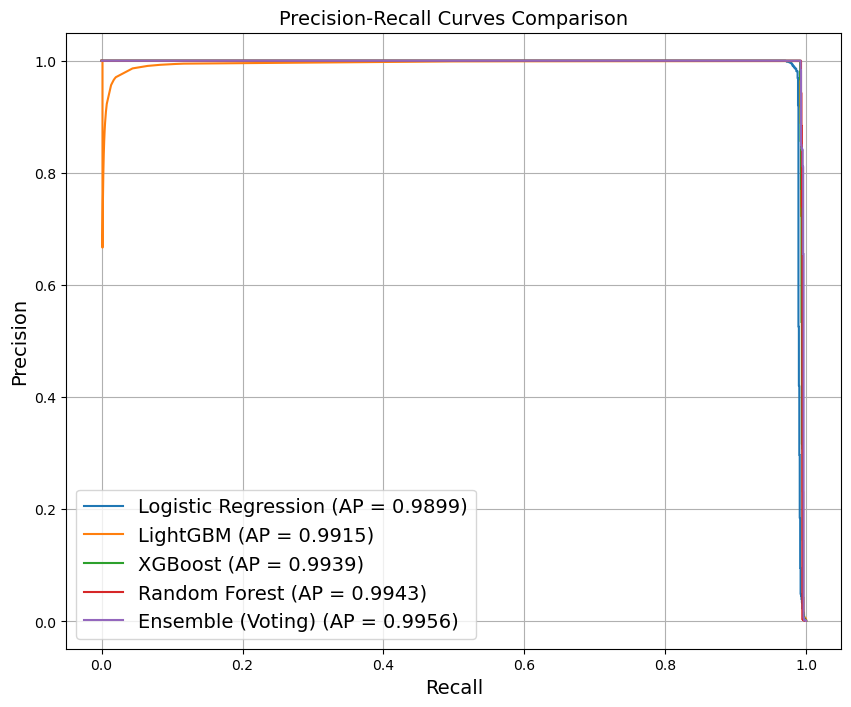

In [57]:
# Visualize model performance comparisons
print("\nGenerating ROC Curves...")

# Prepare models dict with proper test data for plotting
models_for_plotting = {}
for model_name, model in models_dict.items():
    if model_name == 'Logistic Regression':
        models_for_plotting[model_name] = (model, X_test_scaled)
    else:
        X_test_eval = X_test_fe
        if model_name == 'XGBoost':
            X_test_eval = X_test_fe[X_train_fe.columns]
        models_for_plotting[model_name] = (model, X_test_eval)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (model, X_test_eval) in models_for_plotting.items():
    y_proba = model.predict_proba(X_test_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for model_name, (model, X_test_eval) in models_for_plotting.items():
    y_proba = model.predict_proba(X_test_eval)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Cost-Benefit Analysis and Business Impact

In fraud detection, it's crucial to consider the business impact of different types of errors:
- **False Positives (Type I Error)**: Legitimate transactions flagged as fraud → Customer inconvenience, potential revenue loss
- **False Negatives (Type II Error)**: Fraudulent transactions missed → Direct financial loss, regulatory penalties

The cost ratio is typically heavily skewed, with false negatives being much more expensive than false positives.

In [58]:
def cost_benefit_analysis(y_true, y_pred, cost_fp=1, cost_fn=10, avg_transaction_value=1000):
    """
    Perform detailed cost-benefit analysis for fraud detection

    Parameters:
    - cost_fp: Cost of false positive (inconvenience cost)
    - cost_fn: Cost of false negative (fraud loss multiplier)
    - avg_transaction_value: Average transaction value for cost calculation
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate costs
    fp_cost = fp * cost_fp * avg_transaction_value
    fn_cost = fn * cost_fn * avg_transaction_value
    total_cost = fp_cost + fn_cost

    # Calculate savings (detected fraud)
    fraud_detected_value = tp * avg_transaction_value

    # Calculate net benefit
    baseline_cost = (tp + fn) * cost_fn * avg_transaction_value  # Cost if no fraud detection
    net_benefit = baseline_cost - total_cost

    return {
        'False_Positive_Cost': fp_cost,
        'False_Negative_Cost': fn_cost,
        'Total_Cost': total_cost,
        'Fraud_Detected_Value': fraud_detected_value,
        'Net_Benefit': net_benefit,
        'Cost_Reduction_Percentage': (net_benefit / baseline_cost) * 100 if baseline_cost > 0 else 0
    }

# Analyze cost-benefit for all models
print("COST-BENEFIT ANALYSIS")
print("="*60)
print("Assumptions:")
print("- False Positive Cost: $100 per transaction (customer service, opportunity cost)")
print("- False Negative Cost: $5000 per transaction (average fraud loss)")
print("- Average Transaction Value: $1000")
print()

cost_analysis_results = []

for model_name, (model, X_test_eval) in models_for_plotting.items():
    y_pred = model.predict(X_test_eval)

    cost_analysis = cost_benefit_analysis(
        y_test, y_pred,
        cost_fp=100,
        cost_fn=5000,
        avg_transaction_value=1000
    )
    cost_analysis['Model'] = model_name
    cost_analysis_results.append(cost_analysis)

    print(f"\n{model_name}:")
    print(f"  Total Cost: ${cost_analysis['Total_Cost']:,.2f}")
    print(f"  Net Benefit: ${cost_analysis['Net_Benefit']:,.2f}")
    print(f"  Cost Reduction: {cost_analysis['Cost_Reduction_Percentage']:.2f}%")

cost_df = pd.DataFrame(cost_analysis_results)
print(f"\nCost-Benefit Summary:")
print(cost_df[['Model', 'Total_Cost', 'Net_Benefit', 'Cost_Reduction_Percentage']].round(2))

COST-BENEFIT ANALYSIS
Assumptions:
- False Positive Cost: $100 per transaction (customer service, opportunity cost)
- False Negative Cost: $5000 per transaction (average fraud loss)
- Average Transaction Value: $1000


Logistic Regression:
  Total Cost: $127,300,000.00
  Net Benefit: $8,072,700,000.00
  Cost Reduction: 98.45%

Logistic Regression:
  Total Cost: $127,300,000.00
  Net Benefit: $8,072,700,000.00
  Cost Reduction: 98.45%

LightGBM:
  Total Cost: $73,600,000.00
  Net Benefit: $8,126,400,000.00
  Cost Reduction: 99.10%

LightGBM:
  Total Cost: $73,600,000.00
  Net Benefit: $8,126,400,000.00
  Cost Reduction: 99.10%

XGBoost:
  Total Cost: $215,000,000.00
  Net Benefit: $7,985,000,000.00
  Cost Reduction: 97.38%

XGBoost:
  Total Cost: $215,000,000.00
  Net Benefit: $7,985,000,000.00
  Cost Reduction: 97.38%

Random Forest:
  Total Cost: $70,000,000.00
  Net Benefit: $8,130,000,000.00
  Cost Reduction: 99.15%

Random Forest:
  Total Cost: $70,000,000.00
  Net Benefit: $8,130,